In [1]:
import numpy as np
import tensorflow as tf
import json
import cv2
from scipy.io import loadmat

GESTURE_TYPES = 11
LABEL_DICT = {k:i for i,k in enumerate([21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])}
CONNECTION_LABELS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (5, 6), (6, 7), (7, 8),
    (9, 10), (10, 11), (11, 12),
    (13, 14), (14, 15), (15, 16),
    (17, 18), (18, 19), (19, 20),
    (0, 5), (5, 9), (9, 13), (13, 17), (0, 17)
]

In [2]:
keypoints = loadmat("mediapipe.mat")["keypoints"]
labels = loadmat("mediapipe.mat")["labels"].squeeze()

In [3]:
def normalize(keypoints):
    for i in range(len(keypoints)):
        keypoints[i] = 1 - keypoints[i]
        keypoints[i] -= keypoints[i, 0]
        keypoints[i] /= np.linalg.norm(keypoints[i, 0] - keypoints[i, 9])
        theta = -np.arcsin(keypoints[i, 9, 0])
        rotation = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        keypoints[i, :, :2] = keypoints[i, :, :2] @ rotation

        theta2 = np.arcsin(keypoints[i, 9, 2])
        rotation2 = np.array([
            [np.cos(theta2), -np.sin(theta2)],
            [np.sin(theta2), np.cos(theta2)]
        ])
        keypoints[i, :, 1:3] = keypoints[i, :, 1:3] @ rotation2
normalize(keypoints)

## Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = keypoints
x, y, z = np.shape(X)
X = X.reshape((x, y * z))
y = labels

In [6]:
# Train, test sets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# SVM

In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [8]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [9]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [11]:
y_pred = clf.predict(X_test)

In [13]:
print(np.mean(cross_val_score(clf, X, y, cv=10)))

0.8624558998608245


# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt

In [15]:
# Train, test sets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Preparing of a list of n_estimators values to tune
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

In [17]:
# Loop through the list of estimators to obtain the accuracies
train_accuracies = []
test_accuracies = []
for estimator in n_estimators:
    # Initialize a random forest classifier
    rf_clf = RandomForestClassifier(n_estimators=estimator)
    
    # Start training
    rf_inst = rf_clf.fit(X_train, y_train)
    
    # Obtaining training accuracy
    train_acc = rf_inst.score(X_train, y_train)
    train_accuracies.append(train_acc)
    
    # Obtaining testing accuracy
    test_acc = rf_inst.score(X_test, y_test)
    test_accuracies.append(test_acc)
    
    # Report training stats
    print("Training for estimator = {} done, train accy = {}, test accy = {}".format(estimator, train_acc, test_acc))

Training for estimator = 1 done, train accy = 0.9345098356674492, test accy = 0.8297183554548397
Training for estimator = 2 done, train accy = 0.9388812434226503, test accy = 0.8361929426999029
Training for estimator = 4 done, train accy = 0.9842953128794625, test accy = 0.8789252185173195
Training for estimator = 8 done, train accy = 0.9965190641949324, test accy = 0.8993201683392684
Training for estimator = 16 done, train accy = 0.9996761920181333, test accy = 0.9138879896406604
Training for estimator = 32 done, train accy = 0.9999190480045334, test accy = 0.9190676594367109
Training for estimator = 64 done, train accy = 1.0, test accy = 0.9177727419876983
Training for estimator = 100 done, train accy = 1.0, test accy = 0.9168015539009389
Training for estimator = 200 done, train accy = 1.0, test accy = 0.9216574943347362


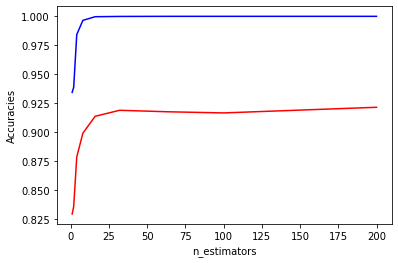

In [18]:
line1, = plt.plot(n_estimators, train_accuracies, 'b')
line2, = plt.plot(n_estimators, test_accuracies, 'r')
plt.ylabel('Accuracies')
plt.xlabel('n_estimators')
plt.show()

In [19]:
# Prepare a list of depth values
depths = np.linspace(1, 32, 32, endpoint=True)

In [20]:
# Loop through the list of depth values to obtain the accuracies
train_accuracies = []
test_accuracies = []
for max_depth in depths:
    # Initialize a random forest classifier
    rf_clf = RandomForestClassifier(max_depth=max_depth)
    
    # Start training
    rf_inst = rf_clf.fit(X_train, y_train)
    
    # Obtaining training accuracy
    train_acc = rf_inst.score(X_train, y_train)
    train_accuracies.append(train_acc)
    
    # Obtaining testing accuracy
    test_acc = rf_inst.score(X_test, y_test)
    test_accuracies.append(test_acc)
    
    # Report training stats
    print("Training for max_depth = {} done, train accy = {}, test accy = {}".format(max_depth, train_acc, test_acc))

Training for max_depth = 1.0 done, train accy = 0.45106451874038694, test accy = 0.4438329556490774
Training for max_depth = 2.0 done, train accy = 0.7326965109689954, test accy = 0.7280673357073486
Training for max_depth = 3.0 done, train accy = 0.7730915567068728, test accy = 0.770152152800259
Training for max_depth = 4.0 done, train accy = 0.8170484902452846, test accy = 0.8154742635157008
Training for max_depth = 5.0 done, train accy = 0.8429531287946248, test accy = 0.838459048235675
Training for max_depth = 6.0 done, train accy = 0.8682911033756983, test accy = 0.8578828099708644
Training for max_depth = 7.0 done, train accy = 0.8924147980247713, test accy = 0.8718031725477501
Training for max_depth = 8.0 done, train accy = 0.9183194365741115, test accy = 0.88410488831337
Training for max_depth = 9.0 done, train accy = 0.9426859872095847, test accy = 0.8986727096147621
Training for max_depth = 10.0 done, train accy = 0.9650287379583907, test accy = 0.9028811913240531
Training for

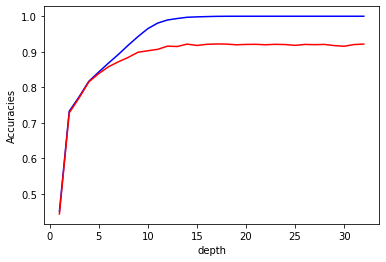

In [21]:
line1, = plt.plot(depths, train_accuracies, 'b')
line2, = plt.plot(depths, test_accuracies, 'r')
plt.ylabel('Accuracies')
plt.xlabel('depth')
plt.show()

In [22]:
n_estimator = 100
max_depth = 20

# Initialize a random forest classifier
rf_clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator)
    
# Start training
rf_inst = rf_clf.fit(X_train, y_train)

# Get prediction accuracy
rf_inst.score(X_test, y_test)

0.9229524117837488